# 1. Loading and transforming data

In [1]:
import os
import pandas as pd
import glob

In [33]:
path = "../Data collection/Historic data/raw data/"
files = glob.glob(path + "/*.csv") 
Datasets = pd.DataFrame()
content = [pd.read_csv(filename, index_col=None) for filename in files]
Datasets = pd.concat(content)

Datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175954 entries, 0 to 4859
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   titre    175954 non-null  object
 1   date     175954 non-null  object
 2   extrait  175723 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


In [2]:
import dateparser

In [ ]:
def format_date(date):
    return  dateparser.parse(str(date)).date()
Datasets["date"] = Datasets["date"].apply(format_date)

In [ ]:
Datasets.to_csv(r".\Outpout\Datasets.csv", index=False)

In [52]:
formated_data=pd.read_csv(r".\Outpout\Datasets.csv")
formated_data.sample(5)

,titre,date,extrait
129915,Vidéo. Université d’été CGEM. Jean-Louis Borlo...,2019-09-13,"Dans une déclaration devant Le360, en marge de..."
60829,Air France relance ses vols vers trois villes...,2020-08-18,Air France relance ses vols vers trois villes ...
160768,Première rencontre entre les opérateurs du tou...,2021-11-02,"\nLa ministre du Tourisme a reçu, ce mardi 2 n..."
170385,Maroc-Sénégal : Signature de sept accords et c...,2013-07-26,"\nLe Roi Mohammed VI, accompagné du Prince Mou..."
107513,"""Il n’y a pas encore de découvertes de pétrole...",2014-03-14,"""Il n’y a pas encore de découvertes de pétrole..."


In [53]:
# convert date column into datetima
formated_data['date'] = pd.to_datetime(formated_data['date'], errors = 'coerce')

# delete rows with null values
formated_data.dropna(inplace=True)
formated_data.isna().sum()

titre      0
date       0
extrait    0
dtype: int64

In [56]:
formated_data.to_csv(r"Outpout\Datasets.csv", index=False)

# 2. Text mining

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
np.set_printoptions(precision=2, linewidth=80)
# from nltk import FreqDist
# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import spacy
# from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
#from bs4 import BeautifulSoup
import unicodedata

from spacy.lang.fr.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer

spacy.load('fr_core_news_md')
import fr_core_news_md #import spacy french stemmer
from sklearn.decomposition import NMF,LatentDirichletAllocation

import pyLDAvis #Nous utilisons pyLDAvis pour créer des visualisations interactives de modèles de sujet.
import pyLDAvis.sklearn


import nltk
nltk.download('punkt')

import seaborn as sns

#output French accents correctly
def convert_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')


#convertisse les documents en minuscule
def lower_text(corpus):
    LowerCorpus=[]
    for doc in corpus:
        lowerDoc=str(doc).lower() #convertissent le texte en minuscules
        lowerDoc=convert_accents(lowerDoc).decode("utf-8") #supprimes les accents
        LowerCorpus.append(lowerDoc)
    return LowerCorpus


def remove_characters(corpus,keep_apostrophes=True):
    filtered_corpus=[]
    for doc in corpus:
        doc = doc.strip()
        if keep_apostrophes:
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            PATTERN = r'[?|$|&|*|%|@|(|)|~|\d]'
            filtered_doc = re.sub(PATTERN, r'', doc)
            filtered_corpus.append(filtered_doc)
        else:
            PATTERN = r'[^a-zA-Z ]'
            #supprimes les urls
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            filtered_doc = re.sub(PATTERN, r'', doc)
        
            filtered_corpus.append(filtered_doc)
    return filtered_corpus


#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus


#recuperer les mots qui apparaissent dans plusieurs documents
def get_mostCommonWords(corpus,max_freq=100):
    vocabulaire=dict() #dictionnaire qui va contenir le nombre d'occurence des mots dans les documents
    for doc in corpus:
        for word in set(doc.split()): #recupere les mots unique de chaque documents
            if word in vocabulaire:
                vocabulaire[word]+=1
            else:
                vocabulaire[word]=1
    
    #recupere les dont le nombre d'occurences dans les documents > max_freq
    mostCommonsWord=[word for word,value in vocabulaire.items() if value>max_freq ]
        
    return mostCommonsWord


# removing stopwords
def remove_stopwords(corpus,mostCommonsWord):
    filtered_corpus=[]
    for tokens in corpus:
        others_sw=["maroc","morocco","marocain","marocaine","marocains","marocaines","maghreb","météorologique","journée",
                   "méteo","retweet","newspic","twitter","com","pic","newspic","illustration"]
        
        #french_sw = stopwords.words('french') 
        french_sw=list(STOP_WORDS) #get french stopwords
        french_sw.extend(others_sw)
        french_sw.extend(mostCommonsWord)
        
        filtered_tokens = [token for token in tokens.split() if token not in french_sw and len(token)>2]
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus


#lemmatisation
def lemm_tokens(corpus):
    
    nlp = fr_core_news_md.load() #initialisation du model "fr_core_news_md" de spacy
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    corpus_lemms=[]
    
    idx_doc=[] #liste qui va stocker les indices documents qui seront dans le corpus
    for idx,document in enumerate(corpus):
        doc = nlp(document)
        lemms=[token.lemma_ for token in doc if token.pos_ in allowed_postags] #recupere les lemms des tokens
        
        if len(lemms)>5: #supprime les document qui ne contient pas plus de 2 mots
            text=' '.join(lemms) #reforme le text du documents separé par espace
            corpus_lemms.append(text)
            idx_doc.append(idx) #ajoute l'indice du documents
            
    return corpus_lemms,idx_doc


#fonction qui supprimes les documents vides ou tres courte
def remove_shortDocument(corpus,min_length=3):
    filtred_corpus=[]
    idx_doc=[]
    for idx,doc in enumerate(corpus):
        
        if len(doc.split())>min_length:
            filtred_corpus.append(doc)
            idx_doc.append(idx)
        
    
    return filtred_corpus,idx_doc


def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=2, threshold=10) # higher threshold fewer phrases
    # Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    corpus_bigram=[" ".join(bigram_mod[doc]) for doc in texts]
    return corpus_bigram


def preprocessing(corpus):
    
    corpus=lower_text(corpus)
    corpus=remove_characters(corpus)
    corpus=tokenize_text(corpus)
    #corpus=remove_mostCommonWords(corpus,max_freq=20)
    corpus=remove_stopwords(corpus)
    corpus,idx_docs=lemm_tokens(corpus)
    
    
    return corpus,idx_docs


# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    
    #trie les indices des mots de chaque topics selon la poids du mots dans le topics
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    #trie les poids des mots de chaques topics,en recuperant les poids des indices deja triée
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights,sorted_indices)])
    
    #recupres les mots selon leurs indices deja triée
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    #concatene chaque mots et sa poids sous formes de tuple (mot,poids)
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]     
    
    return topics


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,weight_threshold=0.0001,display_weights=False,num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic] #recupere les mots et les poids du topic
        
        #seuillage des mots selon le seuil de poids definie
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]
        
        #affiches les "num_terms" de chaque topics
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()


# # Calcul de la cohérence du modèle :
# La cohérence des sujets constituent une mesure pratique pour juger de la qualité d'un modèle de sujet,ici on utilise La Coherence UMass qu'on a implementé nous meme.


def getTopicTerms(pos_topics):
    """
    Fonction qui retourne l'ensemble des mots qui compose chaque topics
    ----Input----
    pos_topics: ensemble des topics qui contients les mots et leurs poids
    ---output---
    topic_terms : ensemble des mots des topics
    
    """
    topic_terms=[]
    for topic in pos_topics:
        #topic=topic[:max_term] #recupere les "max_term" premiere mots et leurs poids
        terms=[]
        for doc in topic:
            terms.append(doc[0]) #recupere justes les mots sans les poids
        
        topic_terms.append(terms) #ajoute l'ensemble des mots
    
    return topic_terms


def compute_coherence_values(tfidf_train_features,feature_names,corpus,data_lemmatized,id2word,max_term=20,limit=50, start=5, step=5):
    """
    Calcul la coherence UMass pour different nombre de topic
    
    Parameters:
    ----------
    tfidf_train_features : features tf-idf qu'on va utiliser pour entrainer chaque model
    feature_names : ensemble des mots contenue dans la matrice tf-idf
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence de chaque topic
    data_lemmatized: corpus sous forme de tokens
    id2word:vocabulaire du corpus au format de gensim
    max_term:le nombre de termes qu'on va prendre dans chaque topic pour calculer la Coherence
    limit : Nombre maximal de topics qu'on va tester

    Returns:
    -------
    best_model : le model qui contient le plus grande coherence
    coherence_values : Valeurs des Cohérences correspondant au modèle avec le nombre respectif de sujets
    """
    
    
    model_list = [] #listes qui va contenir les modeles tester
    coherence_values = [] #liste qui contenir les coherences de chaque models
    # Term Document Frequency
    
    common_corpus = [id2word.doc2bow(text) for text in data_lemmatized] #recupere la matrice bog of word du corpus sous le format de gensim
   
    #print(coherence)
    for num_topics in range(start, limit, step):
        
        model=NMF(n_components=num_topics,random_state=42) #model MNF
        model.fit(tfidf_train_features)
        weights = model.components_ #recupere les poids
        
        model_list.append(model) #ajoute le model la liste des models utilisé
        
        
        topics=get_topics_terms_weights(weights,feature_names)
        
        topic_terms=getTopicTerms(topics)#recupere les mot des de chaque topics
        
        topic_terms=[topics[:max_term] for topics in topic_terms] #recupere les  "max_term" termes avec les plus grandes poids
        
        #calcule du Coherence UMass
        cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_values.append(coherence)
    
    idx_max=np.array(coherence_values).argmax() #recupere l'indice du model qui possede le plus grands coherence
    best_model=model_list[idx_max] #recupere le meilleur models
    

    return best_model,coherence_values


def topic_dominant(model,tdidf_features,corpus,topics):
    
    #document topic distribution :la probabilité des topics pour chaque document
    doc_topic_dist = model.transform(tdidf_features) 
    
    topic_num=[] #liste qui contenir le numero du topic dominant dans chaque documents
    probs_topics=[] #liste qui va contenir les probabilités du topic dominant dans chaque documents
    topic_keywords=[] #liste qui contenir les 5 termes les plus representative du sujet
    text_doc=[] #liste qui va contenir le texte de chaque documents
    
    topic_terms=getTopicTerms(topics) #recupere les mot de chaque topics
    
    num_doc=[]
    
    for i,doc in enumerate(doc_topic_dist):
        text_doc.append(corpus[i]) #recupere le texte du documents
        num_doc.append(i+1) #recupere le numero du documents
        
        idx_max=doc.argmax() #recupere l'indice du topic qui a de la probabilité maximal
        topic_num.append(idx_max) 
        probs_topics.append(round(doc.max(),4)) #recupere la probabilité maximal arrondis
        
        kw=",".join(topic_terms[idx_max][:5]) #recupere les mots clé du topic
        topic_keywords.append(kw)
        
    
    sent_topics_df = pd.DataFrame([num_doc,topic_num,probs_topics,topic_keywords,text_doc]).T
    sent_topics_df.columns=["Num Document","Topic Dominant","Contrib Topic","Key Word","Text"]
    
    return sent_topics_df


[nltk_data] Downloading package punkt to C:\Users\Original
[nltk_data]     Shop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3. processing

In [2]:
clean = pd.read_csv(r".\Outpout\Datasets.csv", parse_dates=['date'])
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175721 entries, 0 to 175720
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   titre    175721 non-null  object        
 1   date     175721 non-null  datetime64[ns]
 2   extrait  175721 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.0+ MB


In [52]:
clean['period']=clean['date'].dt.to_period('M')
clean.sample(5)

,titre,date,extrait,period
136985,Flexibilté du dirham: ce à quoi il faut s’atte...,2017-01-13,Kiosque360. La première phase de flexibilisati...,2017-01
146818,Croissance économique: les prévisions pour 2021,2020-09-28,L’économie nationale devrait afficher une croi...,2020-09
88495,Melilla s’inquiète de ne plus recevoir de pois...,2019-02-20,Melilla s’inquiète de ne plus recevoir de pois...,2019-02
17243,Développement durable : La province d’Ouarzaza...,2017-03-15,Un programme de travail sur la période allant ...,2017-03
16925,Le pont à haubans de Sidi Maarouf livré en 201...,2017-04-28,La réalisation de l’aménagement de l’échangeur...,2017-04


In [53]:
clean.sort_values(by="date" ,inplace=True)

In [55]:
################ Diviser le corpus suivant les periods ######################
corpuses = []
l_periods=list(set(clean.period.values))
l_periods.sort()
for i in range(len(l_periods)-1) :
    indice1=clean.period.values.tolist().index(l_periods[i])
    indice2=clean.period.values.tolist().index(l_periods[i+1])
    liste = []
    for j in range(indice1,indice2,1):
        liste.append(clean.extrait.values[j]) 
    corpuses.append(liste)

In [63]:
periods = list(set(clean.period))
clean_modified = clean.loc[clean.period == l_periods[0] , :]
#dates=pd.to_datetime(clean_modified.iloc[idx_doc]["date"].values)
print(len(clean_modified))
print(len(corpuses[0]))

4
4


In [62]:
corpuses = [ lower_text(corpus) for corpus in corpuses]

In [101]:
def process_corpus(corpus,indice):
    """retourne une liste output"""
    ############# traitement général ################################
    most_commonWords=get_mostCommonWords(corpus,500)
    corpus=remove_stopwords(corpus,most_commonWords)
    corpus,idx_doc=remove_shortDocument(corpus,min_length=3)
    corpus_lemmatized=tokenize_text(corpus) 
    id2word = corpora.Dictionary(corpus_lemmatized)
    vocabulaire=id2word.token2id 
    ########### former la matrice tf-idf #############################
    tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,
                        lowercase=True,ngram_range=(1,2),vocabulary=vocabulaire)
    tfidf_train_features = tfidf.fit_transform(corpus)
    feature_names = tfidf.get_feature_names()
    total_topics = 10
    pos_nmf=NMF(n_components=total_topics,random_state=42,l1_ratio=0.2,max_iter=200)
    pos_nmf.fit(tfidf_train_features) 
    pos_weights = pos_nmf.components_
    pos_topics = get_topics_terms_weights(pos_weights, feature_names)
    topic_terms=getTopicTerms(pos_topics)
    topic_terms=[topics[:20] for topics in topic_terms] 
    common_corpus = [id2word.doc2bow(text) for text in corpus_lemmatized] 
    ####### choix du meilleur model ###################################
    cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, 
                coherence='u_mass')
    coherence = cm.get_coherence()
    best_model,coherence_values=compute_coherence_values(tfidf_train_features,
    feature_names,corpus,corpus_lemmatized,id2word,max_term=20,limit=50)
    ######## résultat du modèle optimal ##############################
    total_topics=best_model.n_components 
    weights = best_model.components_ 
    topics = get_topics_terms_weights(weights,feature_names)
    ################### sujet dominant pour chaque document #############
    sent_topics_df=topic_dominant(best_model,tfidf_train_features,corpus,topics)
    
    
    #sent_topics_sorted = pd.DataFrame()
    #sent_topics_outdf_grpd =sent_topics_df.groupby('Topic Dominant')
    #for i, grp in sent_topics_outdf_grpd:
    #    sent_topics_sorted= pd.concat([sent_topics_sorted,
    #    grp.sort_values(['Contrib Topic'], ascending=[0]).head(1)], axis=0) 
    #sent_topics_sorted.reset_index(drop=True, inplace=True)
    #sent_topics_sorted=sent_topics_sorted.drop(["Num Document"],axis=1)

    ##### Data_For_Plot ########################################################
    period = l_periods[indice]
    clean_modified = clean.loc[clean.period == period , :]
    dates=pd.to_datetime(clean_modified.iloc[idx_doc]["date"].values)
    doc_topic_dist = best_model.transform(tfidf_train_features) 
    labels=getTopicTerms(topics)
    labels=[",".join(topic_term[:5]) for topic_term in labels] 
    df=pd.DataFrame({"text":corpus,"Date":dates,"doc_num":np.arange(len(corpus))})
    stories=df.groupby("doc_num")["text","Date"].min().reset_index() 
    story_topics_for_plot=pd.DataFrame(dict(doc_num=np.arange(doc_topic_dist.shape[0])))
    for idx in range(len(labels)):
        story_topics_for_plot[labels[idx]] = doc_topic_dist[:, idx]
    trends = stories.merge(story_topics_for_plot, on='doc_num')
    mass = lambda x: ((x) * 1.0).sum() / x.shape[0]  
    window = 10
    if len(labels)> 18 :
        aggs = {labels[17]: mass,labels[4]:mass,labels[17]:mass,labels[16]:mass,labels[11]:mass}
    else :
        aggs = {labels[0]: mass,labels[1]:mass,labels[2]:mass,labels[3]:mass,labels[4]:mass}
    data_for_plot=trends.groupby(trends['Date'].dt.date).agg(aggs).rolling(window).mean()

    ######### output de chaque corpus ###############################
    output=[sent_topics_df,story_topics_for_plot,data_for_plot]

    return output


In [96]:
test = process_corpus(corpuses[1],1)

<AxesSubplot:xlabel='Date'>

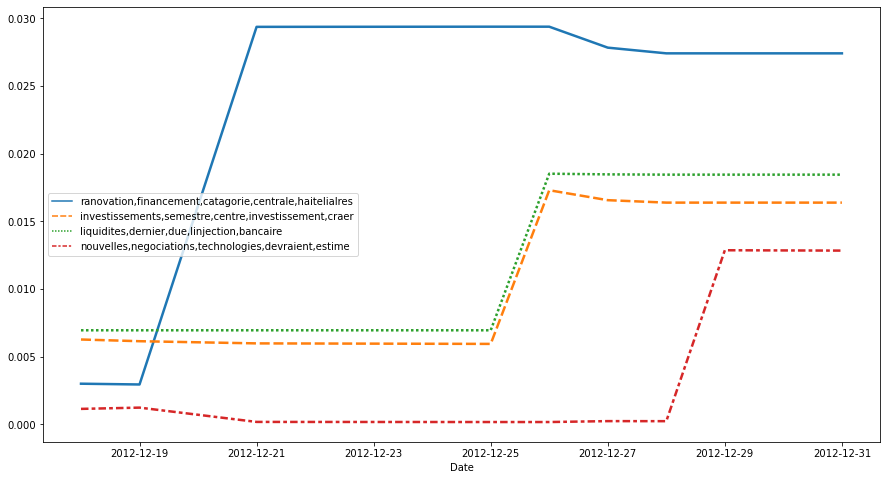

In [97]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[2], palette="tab10", linewidth=2.5)

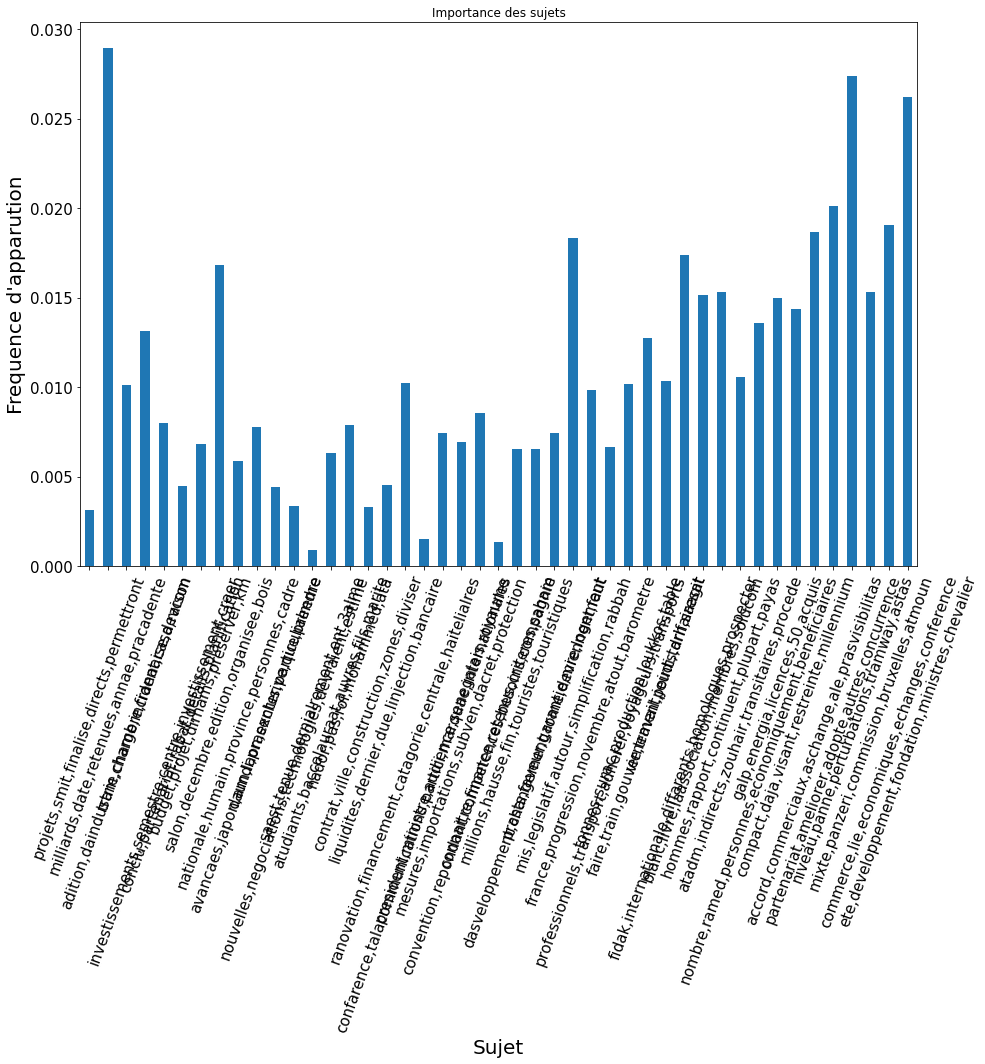

In [98]:
test[1].drop(["doc_num"],axis=1).mean(axis=0).plot(kind='bar', title ="Importance des sujets",
                                                        figsize=(15,10), fontsize=15)
plt.xlabel("Sujet", fontsize=20)
plt.ylabel("Frequence d'apparution", fontsize=20)
plt.xticks(rotation=70)
plt.show()

In [102]:
outputs=[]
i=0
for corpus in corpuses[1:] :
    i=i+1
    outputs.append(process_corpus(corpus,i))

In [100]:
len(corpuses[5])

254

In [36]:
most_commonWords=get_mostCommonWords(corpuses[14],500)
corpus=remove_stopwords(corpuses[14],most_commonWords)
corpus,idx_doc=remove_shortDocument(corpuses[14],min_length=3)

In [18]:
periods = list(set(clean.period))
clean_modified = clean.loc[clean.period == periods[119] , :]
#dates=pd.to_datetime(clean_modified.iloc[idx_doc]["date"].values)
print(len(clean_modified))
print(len(corpuses[119]))

1412
0


In [20]:
corpuses[119]

[]

In [14]:
print(len(clean[clean['period']==periods[120]]))
print(len(corpuses[120]))

NameError: name 'periods' is not defined

In [41]:
idx_doc

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [40]:
len(clean_modified)

461